In [151]:
#Import Packages
import pandas as pd
import numpy as np
import os
import itertools
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import matplotlib
from textwrap import fill
from herbie import Herbie
import pickle
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import pysolar.solar as solar
from geographiclib.geodesic import Geodesic
import xarray as xr
import pytz
from pylr2 import regress2

import sys
sys.path.append('..')
import funcs.ac_funcs as ac
import funcs.plotting as plotting
from config import run_config

import simplekml

pd.options.mode.chained_assignment = None

#Autoreload changed local modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
#Loading the full dataset can take a while
# em27_data_folder = "/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v2_nasrin_correct/"
# dt1_str = '2022-05-01 00:00:00'
# dt2_str =  '2024-01-01 00:00:00'
# tz = 'US/Mountain'
# oof_manage = ac.oof_manager(em27_data_folder,tz)
# flag0_em27_df = oof_manage.load_oof_df_inrange(dt1_str,dt2_str,True)
flag0_em27_df = pd.read_pickle('../../../Data/Pickled_files/flag0_em27_df.pkl')
flag0_em27_df['xco(ppm)'] = flag0_em27_df['xco(ppb)']/1000
flag0_em27_df['xco(ppm)_errir'] = flag0_em27_df['xco(ppb)_error']/1000

In [108]:
em27_resample_interval = None#'5T' #resample at this interval
if em27_resample_interval == None: #if no resample, just copy it 
    em27_resampled = flag0_em27_df.copy()
else:
    em27_resampled = flag0_em27_df.resample(em27_resample_interval).mean(numeric_only=True).dropna() #resample if not none
em27_resampled = em27_resampled.sort_index() #make sure the index is sorted
daily_dfs = [part for _, part in em27_resampled.groupby(pd.Grouper(freq='1D')) if not part.empty] #parse into a list of daily dataframes
for df in daily_dfs: #for each daily dataframe
    min_sza_idx = df['solzen(deg)'].idxmin() #find the sun's peak (min sza)
    df['rise_set'] = ['rise' if idx <= min_sza_idx else 'set' for idx in df.index] #add a column indicating if the sun is rising or setting (before or after peak)
daily_dict = {df.index[0].strftime('%Y-%m-%d'): df for df in daily_dfs} #make a dictionary of the daily dfs so we can refer to it by date instead of just list index


In [109]:
summary_dicts = [] #place to store the summary values to create the dataframe
for df in daily_dfs: #loop through all of the daily dataframes
    date = df.index[0].date() #the dates should all be the same (it's a daily dataframe after all) so just choose the first one
    good_rows = len(df) #how many good rows there are
    min_time = df.index.min().time() #the time of first good row
    max_time = df.index.max().time() #the time of the last good row
    try: #try to get the first sza during rise
        rise_sza_max = df.loc[df['rise_set']=='rise']['solzen(deg)'].max()
    except: #if not (no rise, started after peak) just make it nan
        rise_sza_max = np.nan
    try: #try to get the last sza during set
        set_sza_max = df.loc[df['rise_set']=='set']['solzen(deg)'].max()
    except: #if not (no set, ended before peak) just make it nan
        set_sza_max = np.nan
    summary_dicts.append(dict(date = date,
                              good_rows = good_rows,
                              min_time = min_time,
                              max_time = max_time,
                              rise_sza_max = rise_sza_max,
                              set_sza_max = set_sza_max)) #append all the summary variables
summary_df = pd.DataFrame(summary_dicts) #make the list of dicts into a dataframe
print(summary_df.to_string())

           date  good_rows         min_time         max_time  rise_sza_max  set_sza_max
0    2022-05-24       1661  10:46:37.200000  15:53:20.400000         38.81        37.26
1    2022-05-25       4506         08:16:48  17:47:02.400000         66.76        58.26
2    2022-05-26        780  10:10:22.800000  12:24:14.400000         45.27          NaN
3    2022-06-02       2636         08:50:24  15:09:07.200000         59.92        28.62
4    2022-06-05       1013  07:35:27.600000  09:52:51.600000         73.75          NaN
5    2022-06-06        381  13:03:50.400000  13:58:22.800000         18.66        19.29
6    2022-06-07       1994  09:52:01.200000  14:03:43.200000         48.12        19.61
7    2022-06-09        406  09:11:56.400000  14:07:04.800000         55.68        19.71
8    2022-06-14       3963  07:31:40.800000  18:17:45.600000         74.33        62.13
9    2022-06-15       5514  08:14:09.600000  19:51:14.400000         66.56        79.15
10   2022-06-16       5808  07:2

# Wunch 2009 Method: Daily Anomolies using SZA Bins

In [177]:
def create_binned_summary(df,sza_bin_size,spec_names):
    '''Creates a summary dataframe for binning values on sza for rising and setting sun. Used for getting "daily anomolies" per Wunch 2009
    
    Args:
    df (pd.DataFrame): pandas dataframe containing EM27 data
    sza_bin_size (int, float): size (in degrees) to make the solar zenith angle bins
    spec_names (list): list of strings corresponding to the species wanted. takes the mean of each species for the corresponding "rise" or "set for the sza bin
    
    Returns:
    binned_summary_df (pd.DataFrame): dataframe containing information about the sza binned data'''
    bins = np.arange(0,90,sza_bin_size) #create the bins
    df['sza_bin'] = pd.cut(df['solzen(deg)'],bins) #create a column in the dataframe indicating the bin that row belongs to
    grouped = df.groupby(['sza_bin','rise_set']) #group by the bin as well as rise_set so that they are two separate entities
    binned_summary = [] #initialize a list to store summary data
    for name, group in grouped:
        bin_dict = {} #initialize the binned group's data dict
        bin_dict['tstart'] = group.index[0] #start time of the bin
        bin_dict['tend'] = group.index[-1] #end time of the bin
        bin_dict['tmid'] = bin_dict['tstart']+(bin_dict['tend']-bin_dict['tstart'])/2 #middle time of the bin (can be used for plotting)
        bin_dict['sza_bin'] = name[0] #the sza bin itself
        bin_dict['nobs'] = len(group) #how many observations in that bin
        spec_bin_means = group.mean(numeric_only=True)[spec_names] #get the means of the species we want
        bin_dict.update({col:spec_bin_means[col] for col in spec_names}) #add the means to the bin_dict
        bin_dict['rise_set'] = name[1] #whether it is 'rise' or 'set'
        binned_summary.append(bin_dict) #append that group's info to the summary list
    binned_summary_df = pd.DataFrame(binned_summary)  #make the dataframe from the list of dicts
    return binned_summary_df

def daily_anomaly_creator(binned_summary_df,spec_names):
    '''Create the daily anomoly
    
    Args:
    binned_summary_df (pd.DataFrame): created using create_binned_summary, contains daily summary information
    spec_names (list): list of the species names to use
    
    Returns:
    anom_df (pd.DataFrame): dataframe of the daily anomolies
    skipped_df (pd.DataFrame): dataframe containing information about bins that were skipped and why
    '''

    bin_grouped = binned_summary_df.groupby('sza_bin') #group by sza bin
    #initialize the data lists
    anom_list = []
    skipped_list = []
    for name,group in bin_grouped:
        if len(group)>2: #make sure there's not more than two rows -- should just be one rise and one set for that sza bin
            raise Exception('grouped df greater than 2 -- investigate') 
        if not all(item in group['rise_set'].values for item in ['rise', 'set']): #check that exactly one rise and one set rows exist in the df
            skipped_list.append(dict(skipmode = 'no_match_sza', #document if so
                                        sza_bin = name,
                                        rise_set = group['rise_set'].unique()))
            continue #if there aren't a rise and set, we can't do the anomoly, so just go to the next grouping
        if (group['nobs'].max()>(2*group['nobs'].min())): #check that there aren't more that 2x the number of observations for "rise" compared to set (or vice versa)
            skipped_list.append(dict(skipmode = 'nobs',
                                        sza_bin = name)) #ifso, document and continue
            continue
        rise_row = group.loc[group['rise_set']=='rise'].squeeze() #get the rise data (squeeze gets the value)
        set_row = group.loc[group['rise_set']=='set'].squeeze() #same with set
        anom_dict = {f'{col}_anom':(set_row[col] - rise_row[col]) for col in spec_names} #subtract rise from set for that sza, for each species in the list
        anom_dict.update({'sza_bin':name}) #update the dict with the sza bin
        anom_list.append(anom_dict) #append it to the list
        
    anom_df = pd.DataFrame(anom_list) #create the dataframe for the anomolies
    skipped_df = pd.DataFrame(skipped_list) #create the dataframe for why some sza's may have been skipped
    return anom_df, skipped_df

def get_regression(df,x_spec,y_spec):
    regression = regress2(df[x_spec],df[y_spec])
    x_regr_line = np.linspace(df[x_spec].min(),df[x_spec].max(),10)
    y_regr_line = x_regr_line * regression['slope'] + regression['intercept'] 
    reg_details = dict(lm = regression,
               x_regr_line = x_regr_line,
               y_regr_line = y_regr_line,
               slope = regression['slope'],
               yint = regression['intercept'],
               r2 = regression['r']**2)
    return reg_details

def plot_reg_on_ax(ax,reg_details,labsize = 10):
    annotation = f"R2={round(reg_details['r2'],2)}\nslope={round(reg_details['slope'],3)}\ny_interc={round(reg_details['yint'],3)}"
    ax.plot(reg_details['x_regr_line'],reg_details['y_regr_line'],label = annotation,c = 'grey')
    ax.legend(fontsize = labsize)
    return ax

### Illustration: Single Day

In [202]:
sza_bin_size = 1
spec_names = ['xco2(ppm)','xch4(ppm)','xco(ppm)']
df = daily_dict['2022-10-19'].copy() 
binned_summary_df = create_binned_summary(df,sza_bin_size,spec_names)
anom_df, skipped_df = daily_anomaly_creator(binned_summary_df,spec_names)

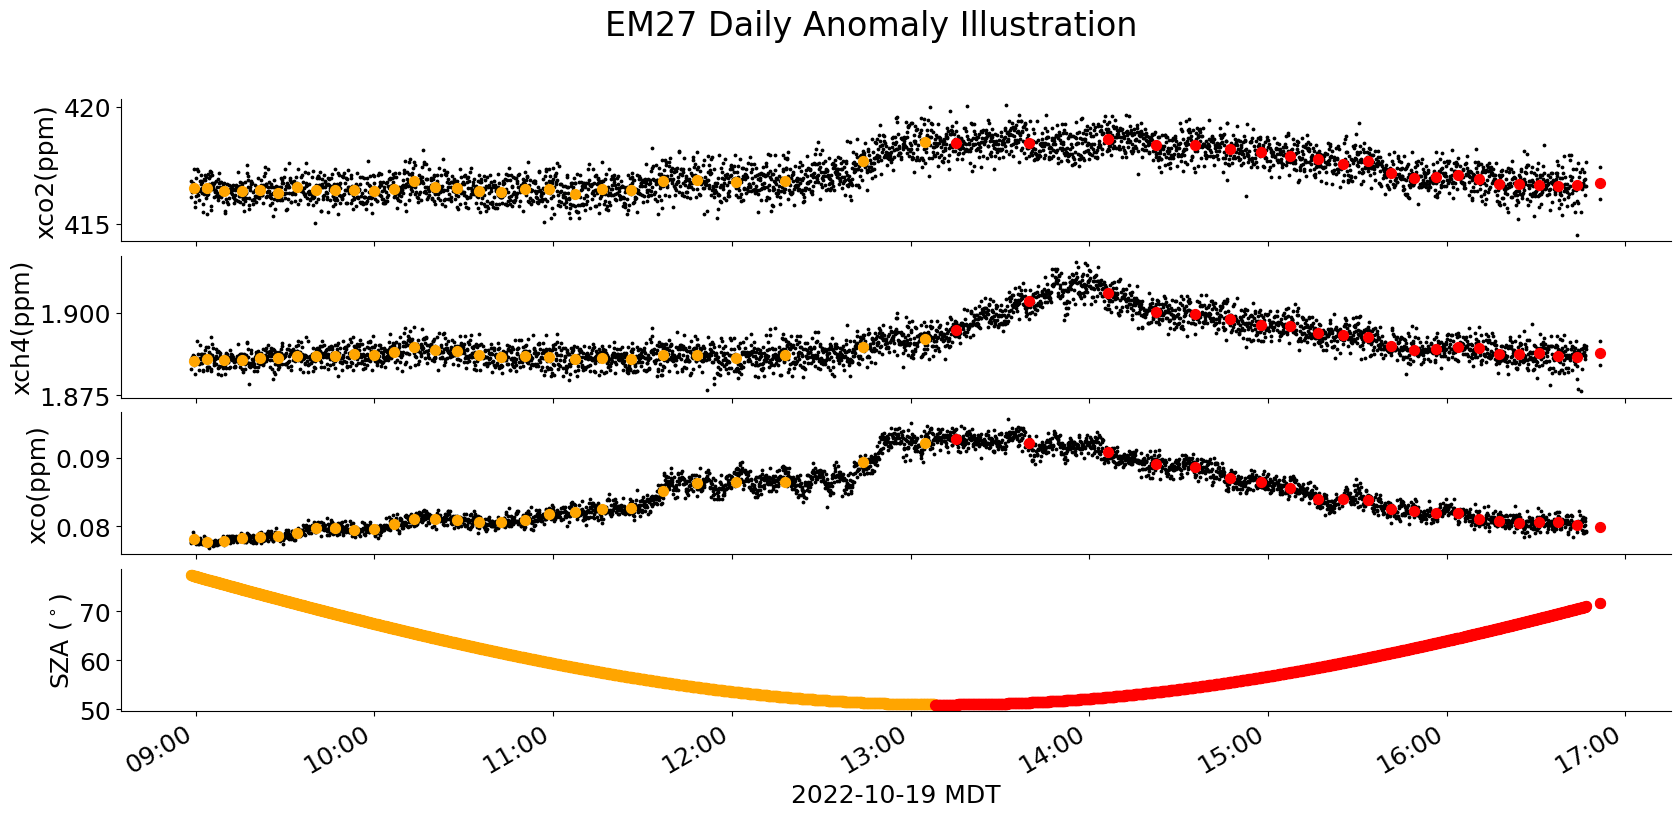

In [203]:
rise_grp = binned_summary_df.loc[binned_summary_df['rise_set'] == 'rise']
set_grp = binned_summary_df.loc[binned_summary_df['rise_set'] == 'set']

fig,axs = plt.subplots(4,1,figsize=(20,9))
labsize = 18
fig.suptitle('EM27 Daily Anomaly Illustration',fontsize = 24)

for row in range(0,3):
    spec = spec_names[row]
    axs[row].scatter(
        df.index,
        df[spec],
        s = 3,
        c = 'k',
        label = 'Collected Data'
    )
    axs[row].scatter(
        rise_grp['tmid'],
        rise_grp[spec],
        s = 50,
        c = 'orange',
        label = f'Sun rising, {sza_bin_size}deg bins'
    )
    axs[row].scatter(
        set_grp['tmid'],
        set_grp[spec],
        s = 50,
        c = 'red',
        label = f'Sun setting, {sza_bin_size}deg bins'
    )
    axs[row].tick_params(labelsize = labsize)
    axs[row].set_ylabel(spec,size = labsize)
    axs[row].spines['top'].set_visible(False)
    axs[row].spines['right'].set_visible(False)

row = 3
rise = df.loc[df['rise_set'] == 'rise']
set = df.loc[df['rise_set'] == 'set']
axs[row].scatter(
    rise.index,
    rise['solzen(deg)'],
    c = 'orange',
    s = 50
)
axs[row].scatter(
    set.index,
    set['solzen(deg)'],
    c = 'red',
    s = 50
)
axs[row].tick_params(labelsize = labsize)
axs[row].set_ylabel('SZA ($^\circ$)',size = labsize)
axs[row].spines['top'].set_visible(False)
axs[row].spines['right'].set_visible(False)
axs[row].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz = df.index.tz))
axs[row].set_xlabel(datetime.datetime.strftime(df.index[0],'%Y-%m-%d %Z'),size = labsize)
plt.subplots_adjust(hspace=0.1)
plt.gcf().autofmt_xdate()
plt.show()



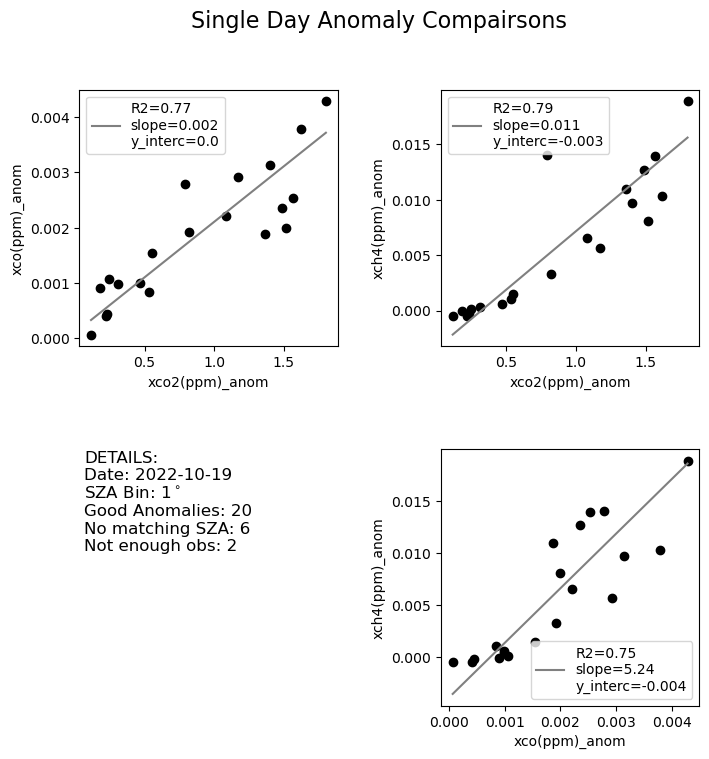

In [204]:
fig,axs = plt.subplots(2,2,figsize = (8,8))
labsize = 10
fig.suptitle('Single Day Anomaly Compairsons',fontsize = 16)

ax = axs[0,0]
x_spec = 'xco2(ppm)_anom'
y_spec = 'xco(ppm)_anom'
ax.scatter(anom_df[x_spec],anom_df[y_spec],c='k')
reg_details = get_regression(anom_df,x_spec,y_spec)
plot_reg_on_ax(ax,reg_details,labsize)
ax.set_xlabel(x_spec,size = labsize)
ax.set_ylabel(y_spec,size = labsize)
ax.tick_params(labelsize = labsize)

ax = axs[0,1]
x_spec = 'xco2(ppm)_anom'
y_spec = 'xch4(ppm)_anom'
ax.scatter(anom_df[x_spec],anom_df[y_spec],c='k')
reg_details = get_regression(anom_df,x_spec,y_spec)
plot_reg_on_ax(ax,reg_details,labsize)
ax.set_xlabel(x_spec,size = labsize)
ax.set_ylabel(y_spec,size = labsize)
ax.tick_params(labelsize = labsize)

ax = axs[1,1]
x_spec = 'xco(ppm)_anom'
y_spec = 'xch4(ppm)_anom'
ax.scatter(anom_df[x_spec],anom_df[y_spec],c='k')
reg_details = get_regression(anom_df,x_spec,y_spec)
plot_reg_on_ax(ax,reg_details,labsize)
ax.set_xlabel(x_spec,size = labsize)
ax.set_ylabel(y_spec,size = labsize)
ax.tick_params(labelsize = labsize)

axs[1,0].axis('off')
text = f"DETAILS:\n\
Date: {datetime.datetime.strftime(df.index[0],'%Y-%m-%d')}\n\
SZA Bin: {sza_bin_size}$^\circ$\n\
Good Anomalies: {len(anom_df)}\n\
No matching SZA: {len(skipped_df.loc[skipped_df['skipmode']=='no_match_sza'])}\n\
Not enough obs: {len(skipped_df.loc[skipped_df['skipmode']=='nobs'])}"
axs[1,0].text(0.02,0.995,text,ha='left',va='top',fontsize = labsize*1.2)


plt.subplots_adjust(hspace=0.4,wspace = 0.4)
plt.show()


## All days

In [205]:
sza_bin_size = 1
spec_names = ['xco2(ppm)','xch4(ppm)','xco(ppm)']

anom_df = pd.DataFrame()
skipped_df = pd.DataFrame()
for date_str, df in daily_dict.items():
    binned_summary_df = create_binned_summary(df,sza_bin_size,spec_names)
    day_anom_df, day_skipped_df = daily_anomaly_creator(binned_summary_df,spec_names)
    date = datetime.datetime.strptime(date_str,'%Y-%m-%d').date()
    day_anom_df['date'] = date
    day_skipped_df['date'] = date
    anom_df = pd.concat([anom_df,day_anom_df])
    skipped_df = pd.concat([skipped_df,day_skipped_df])

anom_df = anom_df.reset_index(drop=True)
skipped_df = skipped_df.reset_index(drop = True)

In [209]:
anom_df = anom_df.loc[anom_df['xch4(ppm)_anom']>-0.04]

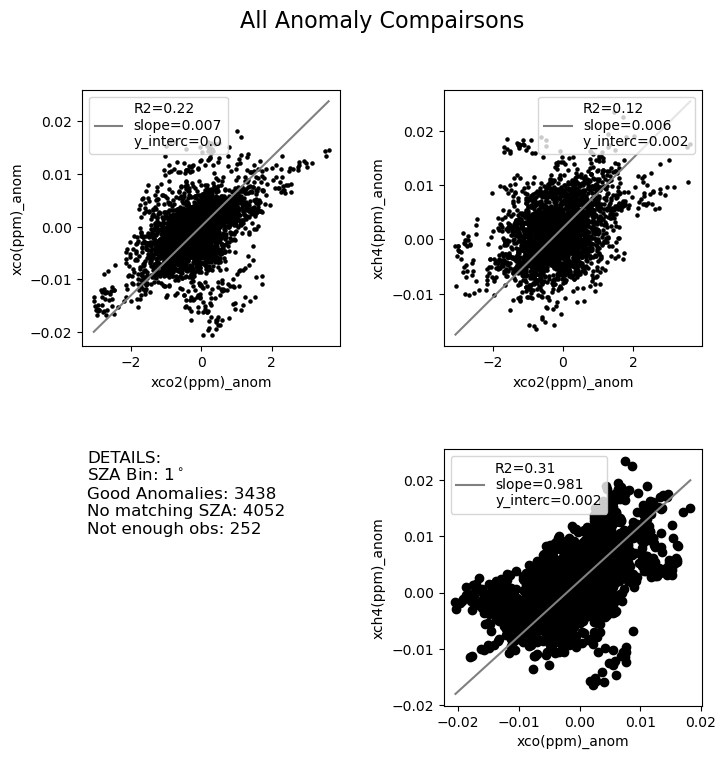

In [215]:
fig,axs = plt.subplots(2,2,figsize = (8,8))
labsize = 10
markersize = 5
fig.suptitle('All Anomaly Compairsons',fontsize = 16)

ax = axs[0,0]
x_spec = 'xco2(ppm)_anom'
y_spec = 'xco(ppm)_anom'
ax.scatter(anom_df[x_spec],anom_df[y_spec],c='k',s = markersize)
reg_details = get_regression(anom_df,x_spec,y_spec)
plot_reg_on_ax(ax,reg_details,labsize)
ax.set_xlabel(x_spec,size = labsize)
ax.set_ylabel(y_spec,size = labsize)
ax.tick_params(labelsize = labsize)

ax = axs[0,1]
x_spec = 'xco2(ppm)_anom'
y_spec = 'xch4(ppm)_anom'
ax.scatter(anom_df[x_spec],anom_df[y_spec],c='k',s = markersize)
reg_details = get_regression(anom_df,x_spec,y_spec)
plot_reg_on_ax(ax,reg_details,labsize)
ax.set_xlabel(x_spec,size = labsize)
ax.set_ylabel(y_spec,size = labsize)
ax.tick_params(labelsize = labsize)

ax = axs[1,1]
x_spec = 'xco(ppm)_anom'
y_spec = 'xch4(ppm)_anom'
ax.scatter(anom_df[x_spec],anom_df[y_spec],c='k')
reg_details = get_regression(anom_df,x_spec,y_spec)
plot_reg_on_ax(ax,reg_details,labsize)
ax.set_xlabel(x_spec,size = labsize)
ax.set_ylabel(y_spec,size = labsize)
ax.tick_params(labelsize = labsize)


axs[1,0].axis('off')
text = f"DETAILS:\n\
SZA Bin: {sza_bin_size}$^\circ$\n\
Good Anomalies: {len(anom_df)}\n\
No matching SZA: {len(skipped_df.loc[skipped_df['skipmode']=='no_match_sza'])}\n\
Not enough obs: {len(skipped_df.loc[skipped_df['skipmode']=='nobs'])}"
axs[1,0].text(0.02,0.995,text,ha='left',va='top',fontsize = labsize*1.2)


plt.subplots_adjust(hspace=0.4,wspace = 0.4)
plt.show()


## Day By Day

In [221]:
daily_anom_summary_list = []
for date, day_anom_df in anom_df.groupby('date'):
    if len(day_anom_df)<5:
        continue
    daily_anom_summary_dict = dict(date = date,
                                   good_anoms = len(day_anom_df))
    
    reg_details = get_regression(day_anom_df,'xco(ppm)_anom','xco2(ppm)_anom')
    daily_anom_summary_dict.update(dict(xco_xco2_slope = reg_details['slope'],
                                        xco_xco2_yint = reg_details['yint'],
                                        xco_xco2_r2 = reg_details['r2']))
    
    reg_details = get_regression(day_anom_df,'xch4(ppm)_anom','xco2(ppm)_anom')
    daily_anom_summary_dict.update(dict(xch4_xco2_slope = reg_details['slope'],
                                        xch4_xco2_yint = reg_details['yint'],
                                        xch4_xco2_r2 = reg_details['r2']))
    
    reg_details = get_regression(day_anom_df,'xch4(ppm)_anom','xco(ppm)_anom')
    daily_anom_summary_dict.update(dict(xch4_xco_slope = reg_details['slope'],
                                        xch4_xco_yint = reg_details['yint'],
                                        xch4_xco_r2 = reg_details['r2']))
    
    daily_anom_summary_list.append(daily_anom_summary_dict)
    
daily_anom_summary_df = pd.DataFrame(daily_anom_summary_list)
daily_anom_summary_df

,date,good_anoms,xco_xco2_slope,xco_xco2_yint,xco_xco2_r2,xch4_xco2_slope,xch4_xco2_yint,xch4_xco2_r2,xch4_xco_slope,xch4_xco_yint,xch4_xco_r2
0,2022-05-24,9,160.867866,0.322754,0.861344,274.149249,0.297349,0.930015,1.704189,-0.000158,0.820663
1,2022-05-25,39,-118.401603,-0.490966,0.016957,138.519710,0.718976,0.011604,1.169914,-0.000341,0.692491
2,2022-06-02,8,191.363288,-0.009524,0.817125,333.024392,-0.669173,0.334662,1.740273,-0.003447,0.061296
3,2022-06-14,33,207.295633,-0.755128,0.548803,217.470449,-1.168127,0.025939,1.049084,-0.001992,0.003731
4,2022-06-15,50,168.231413,-0.107227,0.211661,262.472577,0.044749,0.238846,1.560188,0.000903,0.072438
...,...,...,...,...,...,...,...,...,...,...,...
141,2023-11-17,5,279.101159,0.069241,0.967127,444.655944,-0.069616,0.878654,1.593171,-0.000498,0.774660
142,2023-11-21,18,284.000903,-0.132339,0.917597,307.158264,-0.113016,0.924511,1.081540,0.000068,0.866131
143,2023-11-22,11,268.167680,-0.203298,0.573797,107.108382,-0.556593,0.022706,0.399408,-0.001317,0.243305
144,2023-11-27,14,428.669340,-0.817716,0.616193,299.845707,-0.585510,0.146757,0.699480,0.000542,0.289874


In [239]:
fig = make_subplots(3,1,shared_xaxes=True)

fig.add_trace(go.Scatter(
    x = daily_anom_summary_df['date'],
    y = daily_anom_summary_df['xco_xco2_slope'],
    customdata=np.stack((daily_anom_summary_df['good_anoms'],daily_anom_summary_df['xco_xco2_r2']), axis=-1),
    mode = 'markers',
    marker_color = daily_anom_summary_df['xco_xco2_r2'],
    hovertemplate = #sets up the hover data
    "<b>num anoms = %{customdata[0]} </b><br>" + #bold and include the z information
    "<b>r2 = %{customdata[1]:.2f} </b><br>" ,
),row = 1,col = 1)

fig.add_trace(go.Scatter(
    x = daily_anom_summary_df['date'],
    y = daily_anom_summary_df['xch4_xco2_slope'],
    customdata=np.stack((daily_anom_summary_df['good_anoms'],daily_anom_summary_df['xch4_xco2_r2']), axis=-1),
    mode = 'markers',
    marker_color = daily_anom_summary_df['xch4_xco2_r2'],
    hovertemplate = #sets up the hover data
    "<b>num anoms = %{customdata[0]} </b><br>" + #bold and include the z information
    "<b>r2 = %{customdata[1]:.2f} </b><br>" ,
),row = 2,col = 1)

fig.add_trace(go.Scatter(
    x = daily_anom_summary_df['date'],
    y = daily_anom_summary_df['xch4_xco_slope'],
    customdata=np.stack((daily_anom_summary_df['good_anoms'],daily_anom_summary_df['xch4_xco_r2']), axis=-1),
    mode = 'markers',
    marker_color = daily_anom_summary_df['xch4_xco_r2'],
    hovertemplate = #sets up the hover data
    "<b>num anoms = %{customdata[0]} </b><br>" + #bold and include the z information
    "<b>r2 = %{customdata[1]:.2f} </b><br>" ,
),row = 3,col = 1)

fig.update_layout(
    height = 700
)



# Other plotting

In [ ]:
fig = make_subplots(4,1,shared_xaxes=True)

rise_grp = binned_summary_df.loc[binned_summary_df['rise_set'] == 'rise']
set_grp = binned_summary_df.loc[binned_summary_df['rise_set'] == 'set']

#row 1
row = 1
spec = spec_names[row-1]
fig.add_trace(go.Scatter(
    x = df.index,
    y = df[spec],
    mode = 'markers',
    marker = {'color':'black','size':2},
    name='Collected Data'
),row = row,col = 1)
fig.add_trace(go.Scatter(
    x = rise_grp['tmid'],
    y = rise_grp[spec],
    mode = 'markers',
    marker = {'color':'orange','size':8},
    name = f'Sun rising, {sza_bin_size}deg bin',
),row = row,col = 1)
fig.add_trace(go.Scatter(
    x = set_grp['tmid'],
    y = set_grp[spec],
    mode = 'markers',
    marker = {'color':'red','size':8},
    name = f'Sun setting, {sza_bin_size}deg bin',
),row = row,col = 1)
fig.update_yaxes(title_text=spec, row=row, col=1)

row = 2
spec = spec_names[row-1]
fig.add_trace(go.Scatter(
    x = df.index,
    y = df[spec],
    mode = 'markers',
    marker = {'color':'black','size':2},
    showlegend=False
),row = row,col = 1)
fig.add_trace(go.Scatter(
    x = rise_grp['tmid'],
    y = rise_grp[spec],
    mode = 'markers',
    marker = {'color':'orange','size':8},
    showlegend=False
),row = row,col = 1)
fig.add_trace(go.Scatter(
    x = set_grp['tmid'],
    y = set_grp[spec],
    mode = 'markers',
    marker = {'color':'red','size':8},
    showlegend=False
),row = row,col = 1)
fig.update_yaxes(title_text=spec, row=row, col=1)

row = 3
spec = spec_names[row-1]
fig.add_trace(go.Scatter(
    x = df.index,
    y = df[spec],
    mode = 'markers',
    marker = {'color':'black','size':2},
    showlegend=False
),row = row,col = 1)
fig.add_trace(go.Scatter(
    x = rise_grp['tmid'],
    y = rise_grp[spec],
    mode = 'markers',
    marker = {'color':'orange','size':8},
    showlegend=False
),row = row,col = 1)
fig.add_trace(go.Scatter(
    x = set_grp['tmid'],
    y = set_grp[spec],
    mode = 'markers',
    marker = {'color':'red','size':8},
    showlegend=False
),row = row,col = 1)
fig.update_yaxes(title_text=spec, row=row, col=1)


#row 4
row = 4
rise = df.loc[df['rise_set'] == 'rise']
fig.add_trace(go.Scatter(
    x = rise.index,
    y = rise['solzen(deg)'],
    mode = 'markers',
    marker_color = 'orange',
    showlegend=False
),row = row, col = 1)
set = df.loc[df['rise_set'] == 'set']
fig.add_trace(go.Scatter(
    x = set.index,
    y = set['solzen(deg)'],
    mode = 'markers',
    marker_color = 'red',
    showlegend=False
),row = row, col = 1)
fig.update_yaxes(title_text='SZA (deg)', row=row, col=1)

fig.update_layout(
    height=700,
)
fig.show()


